<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/Session7Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used to solve the assignment for the 7th session of the course. This is the final notebook after a lot of experimentations.
Below specified are a few key assumptions that we take into consideration.
1. For the first block we use 2 Cnn layers as a result of experiments rf=5 is the best to apply the first transition layer
2. In the transition layer we apply the (1,1) first and then maxpooling which we call as combine and compress
3. We try to keep the model param size under ~ 8/8.5k and epoch under 15

## Helper Elements

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 15
lr = 1e-3

Random seed set as 42
cuda


## Data Read and Preprocess

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


In [9]:
# downloading train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 100531997.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39333053.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6882416.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


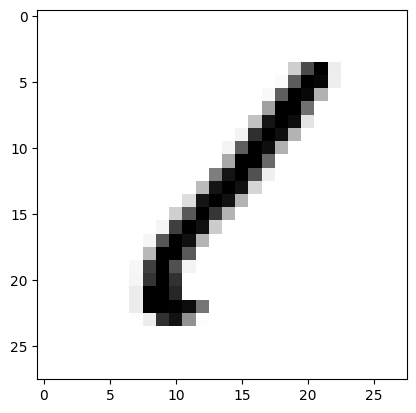

In [11]:
## Basic Data Statistics
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


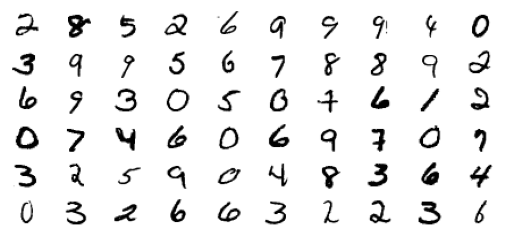

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Basic Model Setup
* Basic Cnn Model under the guidelines
* Application of Batchnorm as first step to regularization
* Application of Cnn as the final classification layer

In [18]:
class Mnist_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [19]:
# New Model Instance
baseline_model = Mnist_Baseline(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]             156
       BatchNorm2d-8           [-1, 12, 24, 24]              24
              ReLU-9           [-1, 12, 24, 24]               0
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,308
      BatchNorm2d-12           [-1, 12, 10, 10]              24
             ReLU-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

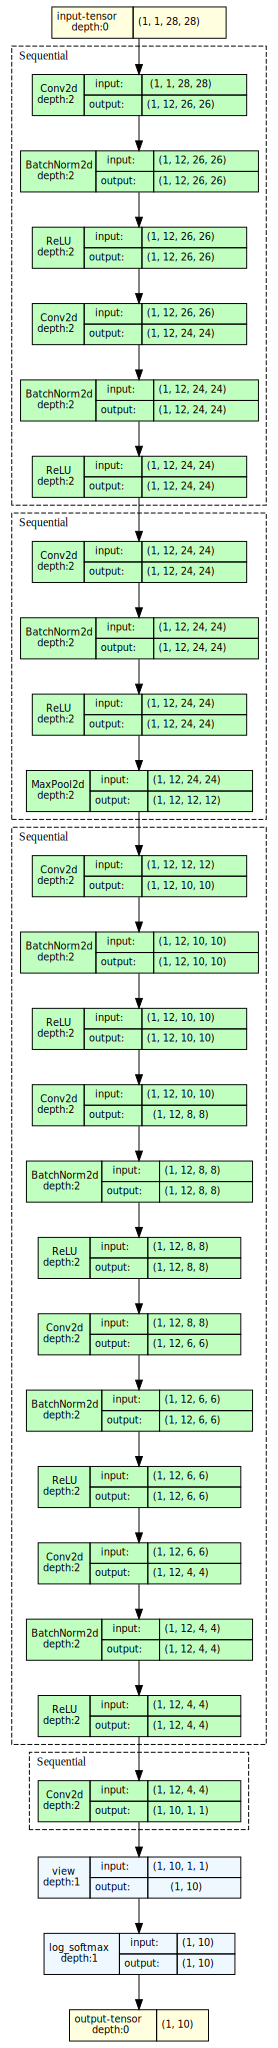

In [20]:
# graphical representation of the model architecture
model_graph = draw_graph(baseline_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [21]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [22]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [23]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [24]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.2986378018249835 Avg Train Metric: 0.8092362558218971: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Function Took 20.1813 seconds


Avg Test Loss: 0.06780259069526874 Avg Test Metric: 0.9801386979561818: 100%|██████████| 79/79 [00:03<00:00, 26.00it/s]


Function Took 3.0501 seconds
Epoch 1


Avg Train Loss: 0.057823663336167265 Avg Train Metric: 0.9821715607826136: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Function Took 19.1870 seconds


Avg Test Loss: 0.04726444594738887 Avg Test Metric: 0.9837311317649069: 100%|██████████| 79/79 [00:02<00:00, 29.33it/s]


Function Took 2.7001 seconds
Epoch 2


Avg Train Loss: 0.043327810915945564 Avg Train Metric: 0.9874869452864885: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]


Function Took 17.5388 seconds


Avg Test Loss: 0.04337791872175434 Avg Test Metric: 0.9842973653274246: 100%|██████████| 79/79 [00:02<00:00, 34.39it/s]


Function Took 2.3077 seconds
Epoch 3


Avg Train Loss: 0.03539531875147558 Avg Train Metric: 0.9891170037072351: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Function Took 18.8862 seconds


Avg Test Loss: 0.036620656827087456 Avg Test Metric: 0.9873603582382202: 100%|██████████| 79/79 [00:02<00:00, 35.47it/s]


Function Took 2.2324 seconds
Epoch 4


Avg Train Loss: 0.031165338151141017 Avg Train Metric: 0.9906810603416296: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


Function Took 17.2984 seconds


Avg Test Loss: 0.036541674608848045 Avg Test Metric: 0.9869906012016006: 100%|██████████| 79/79 [00:02<00:00, 34.47it/s]


Function Took 2.3081 seconds
Epoch 5


Avg Train Loss: 0.02760564338148776 Avg Train Metric: 0.9911122670305818: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Function Took 18.3795 seconds


Avg Test Loss: 0.029719877273398393 Avg Test Metric: 0.9920037019101879: 100%|██████████| 79/79 [00:02<00:00, 33.55it/s]


Function Took 2.3631 seconds
Epoch 6


Avg Train Loss: 0.02514413163077825 Avg Train Metric: 0.992596037352263: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]


Function Took 18.6297 seconds


Avg Test Loss: 0.027581260355389853 Avg Test Metric: 0.9903169115887412: 100%|██████████| 79/79 [00:03<00:00, 25.51it/s]


Function Took 3.1050 seconds
Epoch 7


Avg Train Loss: 0.02184474770091911 Avg Train Metric: 0.9935220702370601: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]


Function Took 17.2464 seconds


Avg Test Loss: 0.030782722291843142 Avg Test Metric: 0.9917029708246642: 100%|██████████| 79/79 [00:02<00:00, 32.37it/s]


Function Took 2.4485 seconds
Epoch 8


Avg Train Loss: 0.019934046801416947 Avg Train Metric: 0.9941217319797605: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]


Function Took 18.1150 seconds


Avg Test Loss: 0.030196609426454843 Avg Test Metric: 0.991044313092775: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s]


Function Took 2.5811 seconds
Epoch 9


Avg Train Loss: 0.019352035934422245 Avg Train Metric: 0.9943953662284656: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]


Function Took 17.4775 seconds


Avg Test Loss: 0.03634690179465975 Avg Test Metric: 0.9892619591725024: 100%|██████████| 79/79 [00:02<00:00, 35.63it/s]


Function Took 2.2266 seconds
Epoch 10


Avg Train Loss: 0.01781754868615395 Avg Train Metric: 0.9943216385871871: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]


Function Took 18.6170 seconds


Avg Test Loss: 0.028469627018711422 Avg Test Metric: 0.9906110001515739: 100%|██████████| 79/79 [00:02<00:00, 34.13it/s]


Function Took 2.3209 seconds
Epoch 11


Avg Train Loss: 0.015618731719635324 Avg Train Metric: 0.995635234343726: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]


Function Took 17.4628 seconds


Avg Test Loss: 0.029253691706741584 Avg Test Metric: 0.9899078215224834: 100%|██████████| 79/79 [00:03<00:00, 22.88it/s]


Function Took 3.4638 seconds
Epoch 12


Avg Train Loss: 0.016562731543268913 Avg Train Metric: 0.9948351224348235: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]


Function Took 18.3335 seconds


Avg Test Loss: 0.02780316952730918 Avg Test Metric: 0.9898801981648312: 100%|██████████| 79/79 [00:02<00:00, 35.20it/s]


Function Took 2.2563 seconds
Epoch 13


Avg Train Loss: 0.01518964383595768 Avg Train Metric: 0.9961290003648445: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]


Function Took 17.7460 seconds


Avg Test Loss: 0.027326729006054398 Avg Test Metric: 0.9917674909664106: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s]


Function Took 3.2106 seconds
Epoch 14


Avg Train Loss: 0.013966951865642301 Avg Train Metric: 0.9950562781616569: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Function Took 17.5222 seconds


Avg Test Loss: 0.027051369149733006 Avg Test Metric: 0.9902219727069517: 100%|██████████| 79/79 [00:02<00:00, 35.51it/s]

Function Took 2.2327 seconds


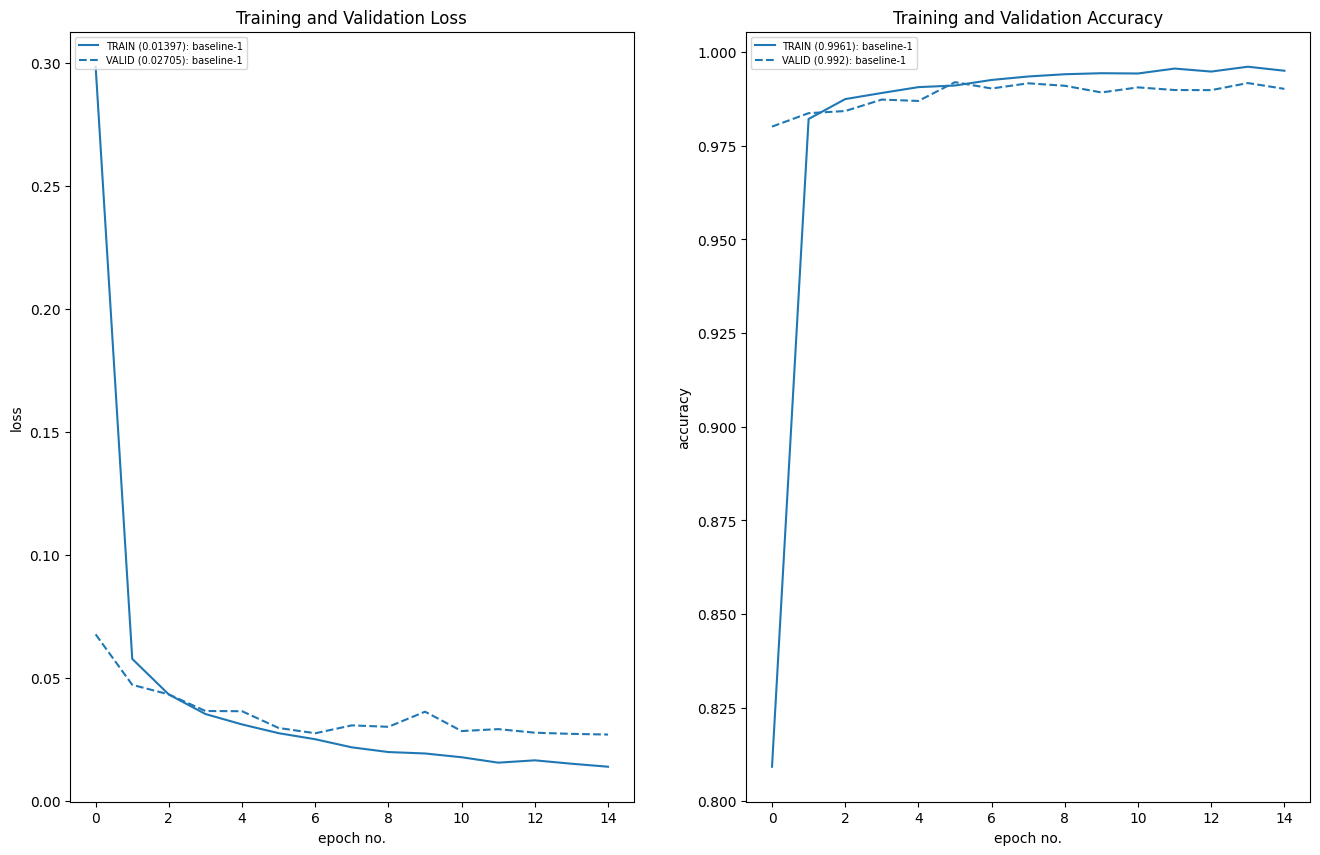

In [25]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Setting up the basic premise for model development
2. Baselin model with 2 sets of convolution blocks and 1 transition block
3. Application of only Batch normalization after every Cnn layer
4. Transition block applied after RF==5

Results:\
Parameters: 8.9k\
Best Training Accuracy: 99.61\
Best Test Accuracy: 99.20

Analysis:
1. As a Baseline model extremely effective with consistent results ie Accuracy>99 for both train & test
2. Diverging gap between both loss metrics of Train & Test

## Overfitting Killer
* Application of dropout layers to solve the problem of overfitting
* In experiments dropout was tried at block level and also layer level and the former was found to be more effective

In [27]:
class Mnist_Baseline_Dropout(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline_Dropout, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [29]:
# New Model Instance
baseline_model_2 = Mnist_Baseline_Dropout(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             156
      BatchNorm2d-10           [-1, 12, 24, 24]              24
             ReLU-11           [-1, 12, 24, 24]               0
        MaxPool2d-12           [-1, 12, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]           1,308
      BatchNorm2d-14           [-1, 12,

In [30]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [31]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.4469337827091151 Avg Train Metric: 0.7211955099154129: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]


Function Took 19.2802 seconds


Avg Test Loss: 0.09873904085046128 Avg Test Metric: 0.9702320702468292: 100%|██████████| 79/79 [00:02<00:00, 36.04it/s]


Function Took 2.1975 seconds
Epoch 1


Avg Train Loss: 0.09620239464903692 Avg Train Metric: 0.9681225782518448: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]


Function Took 17.3516 seconds


Avg Test Loss: 0.059870537087509904 Avg Test Metric: 0.9825304565550406: 100%|██████████| 79/79 [00:02<00:00, 35.93it/s]


Function Took 2.2062 seconds
Epoch 2


Avg Train Loss: 0.0704014442428184 Avg Train Metric: 0.9776249449136161: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]


Function Took 19.1470 seconds


Avg Test Loss: 0.03658211241252249 Avg Test Metric: 0.9907987110222443: 100%|██████████| 79/79 [00:02<00:00, 35.93it/s]


Function Took 2.2065 seconds
Epoch 3


Avg Train Loss: 0.059107019166861265 Avg Train Metric: 0.9820423321937447: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]


Function Took 17.1525 seconds


Avg Test Loss: 0.04102815318664041 Avg Test Metric: 0.9883622821373276: 100%|██████████| 79/79 [00:02<00:00, 33.27it/s]


Function Took 2.3885 seconds
Epoch 4


Avg Train Loss: 0.05433312237266697 Avg Train Metric: 0.9834925960630242: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]


Function Took 19.1511 seconds


Avg Test Loss: 0.043232350745768866 Avg Test Metric: 0.9849085853069643: 100%|██████████| 79/79 [00:02<00:00, 34.45it/s]


Function Took 2.3003 seconds
Epoch 5


Avg Train Loss: 0.04827989981984342 Avg Train Metric: 0.9850054653977026: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Function Took 17.5246 seconds


Avg Test Loss: 0.03534238557390208 Avg Test Metric: 0.9878970203520376: 100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


Function Took 2.7901 seconds
Epoch 6


Avg Train Loss: 0.04717924132365296 Avg Train Metric: 0.9853691795487394: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]


Function Took 17.7847 seconds


Avg Test Loss: 0.02906794305684493 Avg Test Metric: 0.9906689358662956: 100%|██████████| 79/79 [00:02<00:00, 35.09it/s]


Function Took 2.2573 seconds
Epoch 7


Avg Train Loss: 0.042823538719328924 Avg Train Metric: 0.9869073229049569: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]


Function Took 17.7237 seconds


Avg Test Loss: 0.02909539774343183 Avg Test Metric: 0.9916595824157135: 100%|██████████| 79/79 [00:03<00:00, 26.13it/s]


Function Took 3.0288 seconds
Epoch 8


Avg Train Loss: 0.04150130183372432 Avg Train Metric: 0.987350381132382: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]


Function Took 17.6870 seconds


Avg Test Loss: 0.028578838159601334 Avg Test Metric: 0.9910919145692753: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s]


Function Took 2.2644 seconds
Epoch 9


Avg Train Loss: 0.03920100321387574 Avg Train Metric: 0.9868620951800967: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Function Took 18.8974 seconds


Avg Test Loss: 0.02613847448396249 Avg Test Metric: 0.993008099779298: 100%|██████████| 79/79 [00:02<00:00, 27.84it/s]


Function Took 2.8445 seconds
Epoch 10


Avg Train Loss: 0.03760771609511155 Avg Train Metric: 0.9879435688447851: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]


Function Took 17.5676 seconds


Avg Test Loss: 0.025068215426069365 Avg Test Metric: 0.9909485736979714: 100%|██████████| 79/79 [00:02<00:00, 35.84it/s]


Function Took 2.2140 seconds
Epoch 11


Avg Train Loss: 0.03844297370925021 Avg Train Metric: 0.9881297014415391: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]


Function Took 18.8434 seconds


Avg Test Loss: 0.02782243902535661 Avg Test Metric: 0.9927384415759316: 100%|██████████| 79/79 [00:02<00:00, 35.53it/s]


Function Took 2.2321 seconds
Epoch 12


Avg Train Loss: 0.03620558568506813 Avg Train Metric: 0.9884489195179075: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]


Function Took 17.5765 seconds


Avg Test Loss: 0.026315832112715404 Avg Test Metric: 0.9924538973011549: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


Function Took 2.7167 seconds
Epoch 13


Avg Train Loss: 0.03473935504781523 Avg Train Metric: 0.9883078386280328: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]


Function Took 17.8541 seconds


Avg Test Loss: 0.026327962524410855 Avg Test Metric: 0.9924689569050753: 100%|██████████| 79/79 [00:02<00:00, 33.83it/s]


Function Took 2.3431 seconds
Epoch 14


Avg Train Loss: 0.034592379864279446 Avg Train Metric: 0.9890040389256183: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]


Function Took 17.7689 seconds


Avg Test Loss: 0.024515276468252835 Avg Test Metric: 0.9919412717034545: 100%|██████████| 79/79 [00:02<00:00, 26.86it/s]

Function Took 2.9503 seconds


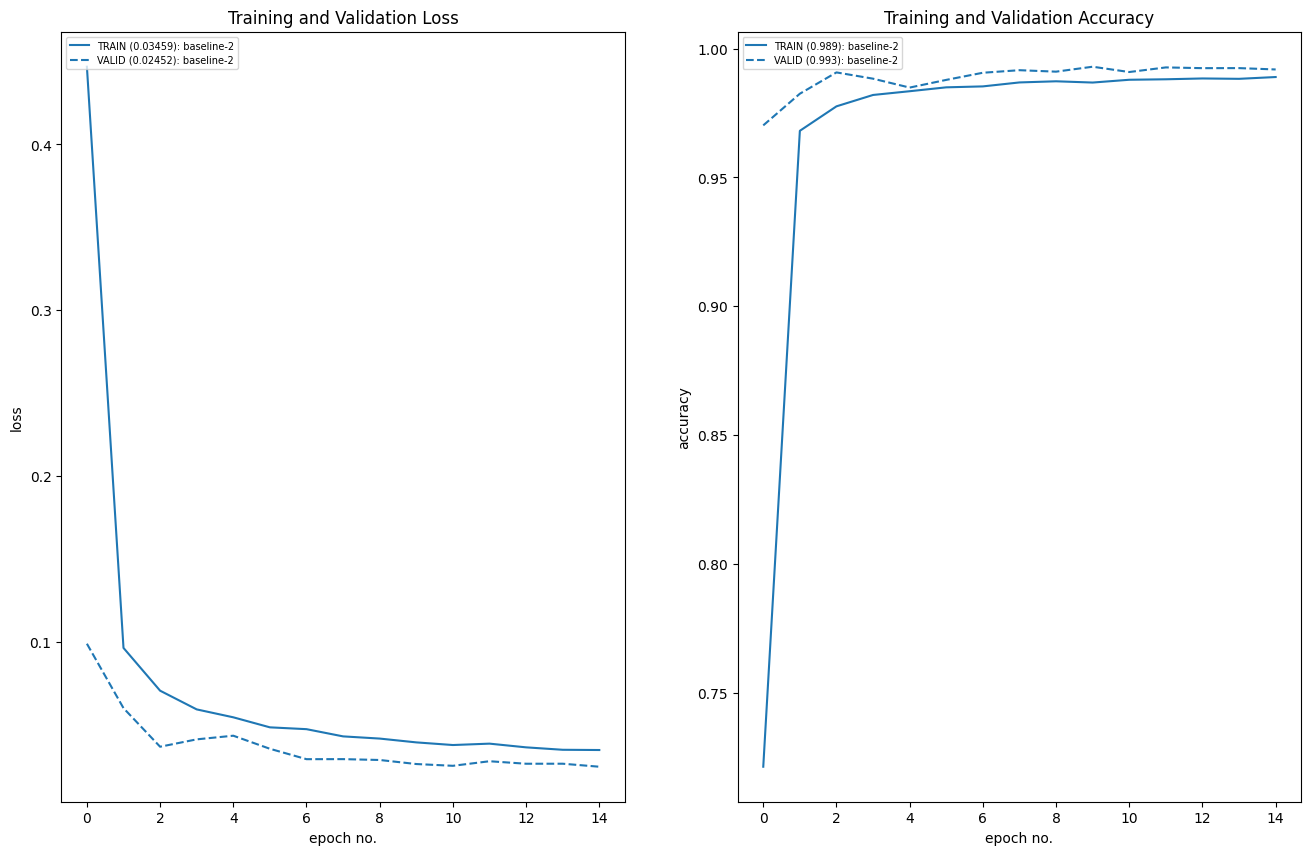

In [33]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:
1. Improve the situation of overfitting by adding dropout layers to the model
2. Closed performance metrics for train and test
Results:\
Parameters: 8.9k\
Best Training Accuracy: 98.99\
Best Test Accuracy: 99.3

Analysis:
1. Though train acc metric has comedown but test metrics are better by substantial margin

## Model Expansion
* Addition of GAP before the classification layer to reduce param space

In [37]:
class Mnist_Baseline_Dropout_GAP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline_Dropout_GAP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [38]:
# New Model Instance
baseline_model_3 = Mnist_Baseline_Dropout_GAP(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             156
      BatchNorm2d-10           [-1, 12, 24, 24]              24
             ReLU-11           [-1, 12, 24, 24]               0
        MaxPool2d-12           [-1, 12, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]           1,308
      BatchNorm2d-14           [-1, 12,

In [39]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_3.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [40]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_3, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_3, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.8948856415842642 Avg Train Metric: 0.6373862372373721: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]


Function Took 21.4680 seconds


Avg Test Loss: 0.24569530087181285 Avg Test Metric: 0.9571971712233145: 100%|██████████| 79/79 [00:02<00:00, 27.47it/s]


Function Took 2.8830 seconds
Epoch 1


Avg Train Loss: 0.1545715034166887 Avg Train Metric: 0.9681487393531718: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]


Function Took 17.7082 seconds


Avg Test Loss: 0.1026571401029448 Avg Test Metric: 0.9735614114169833: 100%|██████████| 79/79 [00:02<00:00, 35.05it/s]


Function Took 2.2624 seconds
Epoch 2


Avg Train Loss: 0.09112352317870298 Avg Train Metric: 0.9775385077574106: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]


Function Took 19.7341 seconds


Avg Test Loss: 0.07233735541754131 Avg Test Metric: 0.9807037069827695: 100%|██████████| 79/79 [00:02<00:00, 35.78it/s]


Function Took 2.2137 seconds
Epoch 3


Avg Train Loss: 0.06962943040350797 Avg Train Metric: 0.9822276449406834: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]


Function Took 17.7533 seconds


Avg Test Loss: 0.05902951218989454 Avg Test Metric: 0.9811635673800602: 100%|██████████| 79/79 [00:02<00:00, 34.64it/s]


Function Took 2.2901 seconds
Epoch 4


Avg Train Loss: 0.060547735633404015 Avg Train Metric: 0.9823079444706313: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]


Function Took 18.4807 seconds


Avg Test Loss: 0.04490953833572095 Avg Test Metric: 0.9897552773922305: 100%|██████████| 79/79 [00:02<00:00, 29.50it/s]


Function Took 2.6870 seconds
Epoch 5


Avg Train Loss: 0.05431106278915077 Avg Train Metric: 0.9850599875073951: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]


Function Took 18.5561 seconds


Avg Test Loss: 0.03127176817093941 Avg Test Metric: 0.9910874645921248: 100%|██████████| 79/79 [00:03<00:00, 24.74it/s]


Function Took 3.2026 seconds
Epoch 6


Avg Train Loss: 0.05089556850564442 Avg Train Metric: 0.9848099392868562: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]


Function Took 17.5375 seconds


Avg Test Loss: 0.03406759407489172 Avg Test Metric: 0.989641910866846: 100%|██████████| 79/79 [00:02<00:00, 33.27it/s]


Function Took 2.3827 seconds
Epoch 7


Avg Train Loss: 0.04566572300259715 Avg Train Metric: 0.9867778436969846: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]


Function Took 19.3007 seconds


Avg Test Loss: 0.03323516282076134 Avg Test Metric: 0.9894650389876547: 100%|██████████| 79/79 [00:02<00:00, 30.38it/s]


Function Took 2.6097 seconds
Epoch 8


Avg Train Loss: 0.04493731970408324 Avg Train Metric: 0.9867096618294462: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]


Function Took 19.0277 seconds


Avg Test Loss: 0.03475238091409607 Avg Test Metric: 0.9883479385436336: 100%|██████████| 79/79 [00:02<00:00, 36.02it/s]


Function Took 2.2065 seconds
Epoch 9


Avg Train Loss: 0.041704652624935515 Avg Train Metric: 0.9873914252212053: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Function Took 25.9156 seconds


Avg Test Loss: 0.0362557417321125 Avg Test Metric: 0.9884402080427243: 100%|██████████| 79/79 [00:03<00:00, 20.26it/s]


Function Took 3.9084 seconds
Epoch 10


Avg Train Loss: 0.03973058394805741 Avg Train Metric: 0.9890451807457247: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


Function Took 21.0925 seconds


Avg Test Loss: 0.028267179156028773 Avg Test Metric: 0.9928300146815143: 100%|██████████| 79/79 [00:02<00:00, 32.86it/s]


Function Took 2.4106 seconds
Epoch 11


Avg Train Loss: 0.04048333931138425 Avg Train Metric: 0.9883672847930811: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]


Function Took 19.0205 seconds


Avg Test Loss: 0.02867737961815128 Avg Test Metric: 0.9920163728013823: 100%|██████████| 79/79 [00:02<00:00, 29.17it/s]


Function Took 2.7159 seconds
Epoch 12


Avg Train Loss: 0.03690234663735416 Avg Train Metric: 0.9905142782847765: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]


Function Took 23.9963 seconds


Avg Test Loss: 0.030859188380049942 Avg Test Metric: 0.9905001988893822: 100%|██████████| 79/79 [00:02<00:00, 28.73it/s]


Function Took 2.7597 seconds
Epoch 13


Avg Train Loss: 0.03654040357962783 Avg Train Metric: 0.9902437863065235: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Function Took 22.1852 seconds


Avg Test Loss: 0.025904014342629553 Avg Test Metric: 0.9920554493047014: 100%|██████████| 79/79 [00:02<00:00, 27.50it/s]


Function Took 2.8792 seconds
Epoch 14


Avg Train Loss: 0.037862303496491334 Avg Train Metric: 0.9879418012938266: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Function Took 21.5183 seconds


Avg Test Loss: 0.024581508116378107 Avg Test Metric: 0.9920323936245109: 100%|██████████| 79/79 [00:02<00:00, 35.59it/s]

Function Took 2.2292 seconds


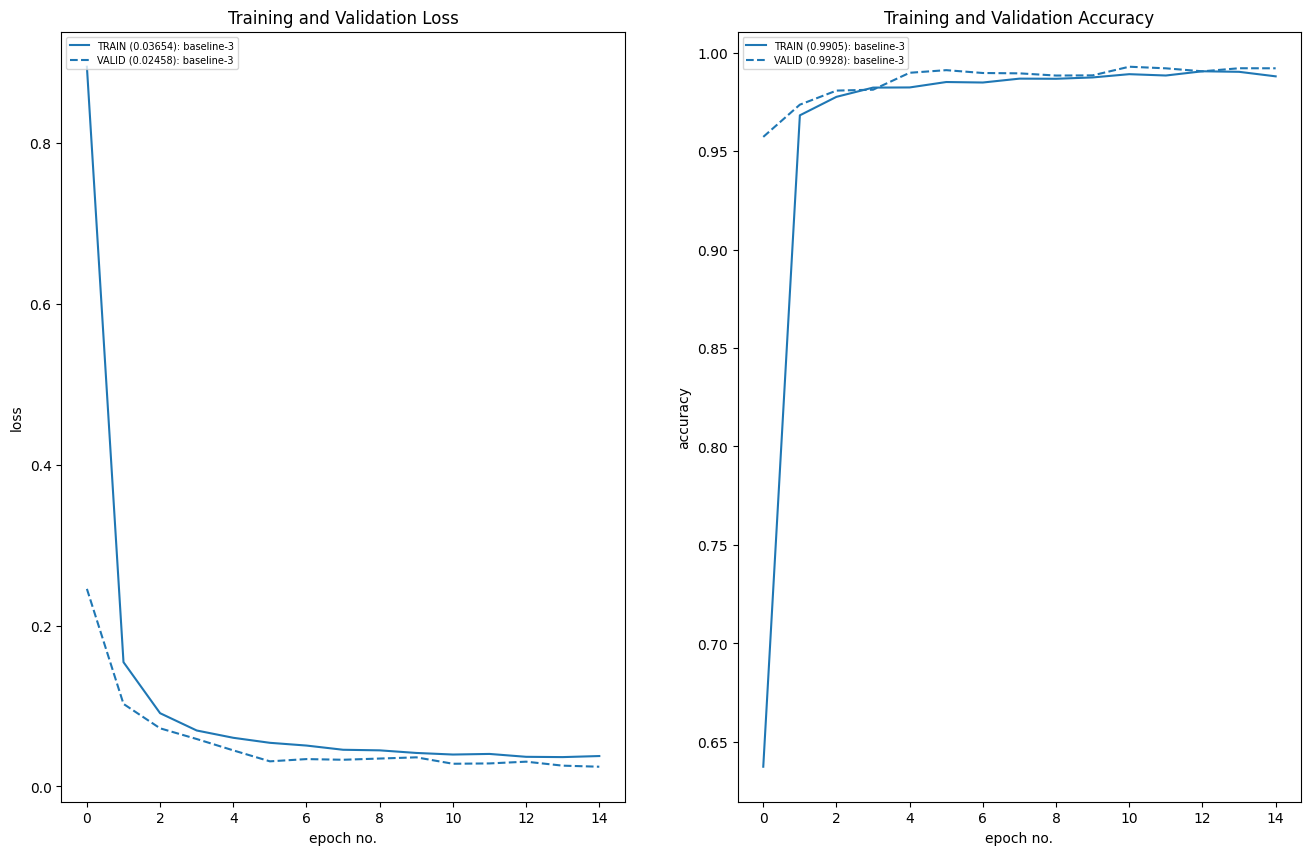

In [41]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-3'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:
1. Application of model size by using a GAP before the classifier
2. Expected tiny dip in performance metrics

Results:\
Parameters: 7114\
Best Training Accuracy: 99.05\
Best Test Accuracy: 99.28

Analysis:
1. Lowered param space due to GAP
2. Miniscul Fall in perf metrics

## Optimization Tricks

Application of lR scheduler with both second and third model

LR starts with 1e-2
and application of gamma for LR scheduler

In [46]:
# New Model Instance
baseline_model_2_new = Mnist_Baseline_Dropout(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_2_new, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             156
      BatchNorm2d-10           [-1, 12, 24, 24]              24
             ReLU-11           [-1, 12, 24, 24]               0
        MaxPool2d-12           [-1, 12, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]           1,308
      BatchNorm2d-14           [-1, 12,

In [47]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2_new.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.83) # lr_t = lr_t-1 * gamma

In [48]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_2_new, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_2_new, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.18397371157972034 Avg Train Metric: 0.8717674584721705: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]


Function Took 17.4358 seconds


Avg Test Loss: 0.05149288348930216 Avg Test Metric: 0.9848157695577114: 100%|██████████| 79/79 [00:02<00:00, 33.52it/s]


Function Took 2.3697 seconds
For next epoch 0.0083
Epoch 1


Avg Train Loss: 0.07004149918700618 Avg Train Metric: 0.9764405674517536: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]


Function Took 18.3275 seconds


Avg Test Loss: 0.03980544330316443 Avg Test Metric: 0.9864615767816954: 100%|██████████| 79/79 [00:02<00:00, 35.63it/s]


Function Took 2.2252 seconds
For next epoch 0.006889
Epoch 2


Avg Train Loss: 0.05699516173257534 Avg Train Metric: 0.9825826557968725: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]


Function Took 17.6129 seconds


Avg Test Loss: 0.0355102552264587 Avg Test Metric: 0.9893080720418617: 100%|██████████| 79/79 [00:03<00:00, 25.30it/s]


Function Took 3.1303 seconds
For next epoch 0.00571787
Epoch 3


Avg Train Loss: 0.05053178657507544 Avg Train Metric: 0.984054882897497: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]


Function Took 18.6108 seconds


Avg Test Loss: 0.027359707559506067 Avg Test Metric: 0.9883829460868353: 100%|██████████| 79/79 [00:02<00:00, 35.36it/s]


Function Took 2.2400 seconds
For next epoch 0.0047458321
Epoch 4


Avg Train Loss: 0.042925042393150675 Avg Train Metric: 0.9869128871065721: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]


Function Took 18.2228 seconds


Avg Test Loss: 0.025747474987366344 Avg Test Metric: 0.9914685578285893: 100%|██████████| 79/79 [00:02<00:00, 31.62it/s]


Function Took 2.5044 seconds
For next epoch 0.003939040643
Epoch 5


Avg Train Loss: 0.04121356419692718 Avg Train Metric: 0.9871739170698723: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]


Function Took 17.6761 seconds


Avg Test Loss: 0.024399650724136118 Avg Test Metric: 0.9916157156606263: 100%|██████████| 79/79 [00:02<00:00, 35.11it/s]


Function Took 2.2590 seconds
For next epoch 0.00326940373369
Epoch 6


Avg Train Loss: 0.03737904041581579 Avg Train Metric: 0.9885032431149026: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]


Function Took 18.6819 seconds


Avg Test Loss: 0.02629464228720039 Avg Test Metric: 0.9912042617797852: 100%|██████████| 79/79 [00:02<00:00, 34.66it/s]


Function Took 2.2878 seconds
For next epoch 0.0027136050989627
Epoch 7


Avg Train Loss: 0.0319798981620948 Avg Train Metric: 0.9893760141024965: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]


Function Took 17.4792 seconds


Avg Test Loss: 0.022969327505812036 Avg Test Metric: 0.992352670506586: 100%|██████████| 79/79 [00:02<00:00, 32.77it/s]


Function Took 2.4201 seconds
For next epoch 0.002252292232139041
Epoch 8


Avg Train Loss: 0.03308948572662506 Avg Train Metric: 0.9908612632293945: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]


Function Took 18.2681 seconds


Avg Test Loss: 0.02222537631581573 Avg Test Metric: 0.9937709615200381: 100%|██████████| 79/79 [00:02<00:00, 26.49it/s]


Function Took 2.9903 seconds
For next epoch 0.001869402552675404
Epoch 9


Avg Train Loss: 0.028683871728306543 Avg Train Metric: 0.9907692194239163: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]


Function Took 17.8222 seconds


Avg Test Loss: 0.020018272176849112 Avg Test Metric: 0.9937933766389195: 100%|██████████| 79/79 [00:02<00:00, 29.31it/s]


Function Took 2.7014 seconds
For next epoch 0.0015516041187205853
Epoch 10


Avg Train Loss: 0.027507647614814897 Avg Train Metric: 0.9911383096851519: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]


Function Took 17.4423 seconds


Avg Test Loss: 0.018731631895805755 Avg Test Metric: 0.9938139198701593: 100%|██████████| 79/79 [00:02<00:00, 35.04it/s]


Function Took 2.2632 seconds
For next epoch 0.0012878314185380856
Epoch 11


Avg Train Loss: 0.02618712790423075 Avg Train Metric: 0.9920631292532248: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]


Function Took 18.5426 seconds


Avg Test Loss: 0.02021337155240906 Avg Test Metric: 0.9923771710335454: 100%|██████████| 79/79 [00:02<00:00, 35.12it/s]


Function Took 2.2570 seconds
For next epoch 0.001068900077386611
Epoch 12


Avg Train Loss: 0.02472797732441319 Avg Train Metric: 0.9920203967897623: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]


Function Took 17.8422 seconds


Avg Test Loss: 0.019300855549576963 Avg Test Metric: 0.9939869355551804: 100%|██████████| 79/79 [00:02<00:00, 35.16it/s]


Function Took 2.2594 seconds
For next epoch 0.0008871870642308871
Epoch 13


Avg Train Loss: 0.023590608825857468 Avg Train Metric: 0.9931409253494572: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]


Function Took 18.4150 seconds


Avg Test Loss: 0.018821435004967867 Avg Test Metric: 0.9946736467035511: 100%|██████████| 79/79 [00:02<00:00, 35.16it/s]


Function Took 2.2582 seconds
For next epoch 0.0007363652633116363
Epoch 14


Avg Train Loss: 0.022993272705215104 Avg Train Metric: 0.9933298489432345: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Function Took 18.8012 seconds


Avg Test Loss: 0.019186293682351686 Avg Test Metric: 0.9918418752996228: 100%|██████████| 79/79 [00:03<00:00, 25.06it/s]

Function Took 3.1619 seconds
For next epoch 0.0006111831685486581


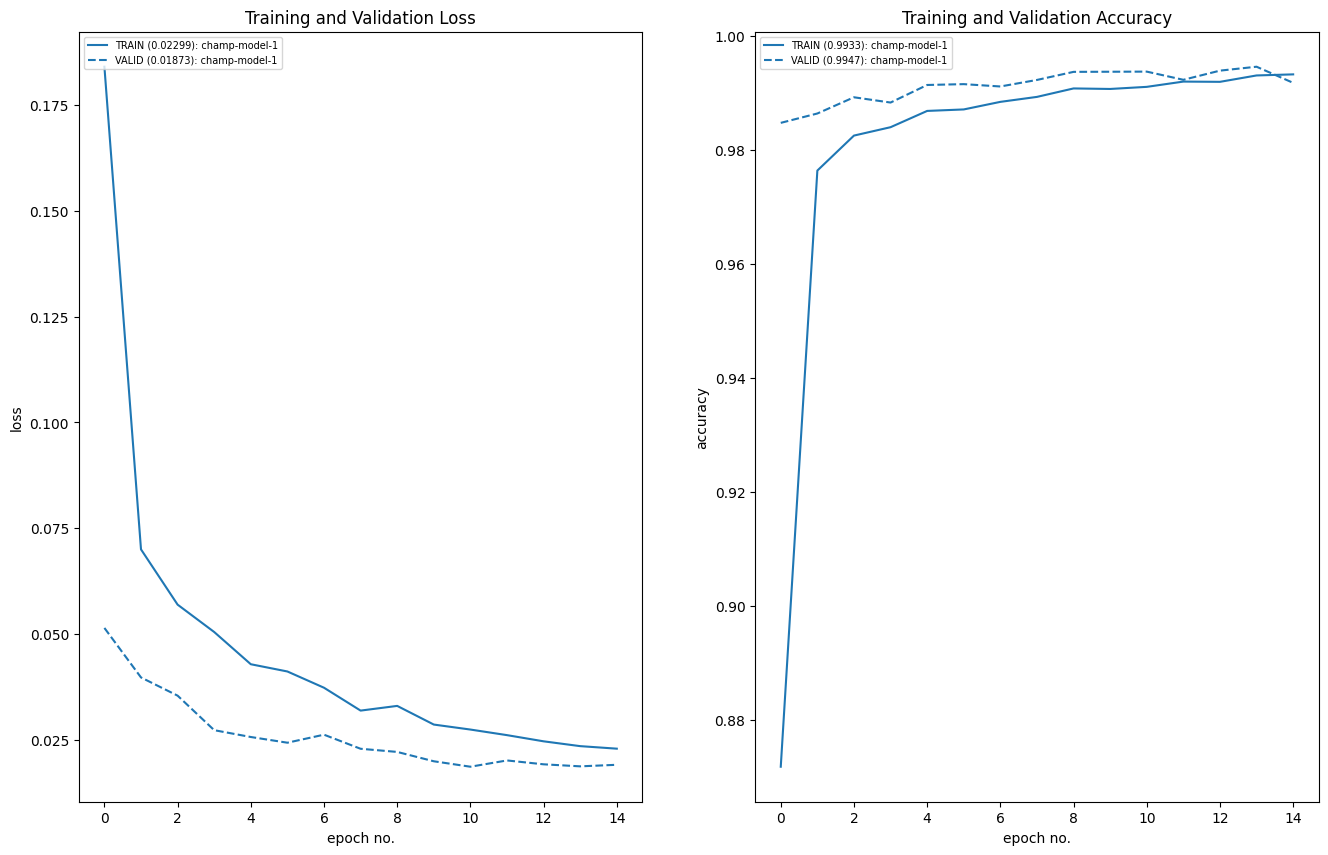

In [49]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champ-model-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:
1. Application of LR uisng ExponentialLR on Drop out baseline model
2. Increased validation Accuracy

Results:\
Parameters: 8.9k\
Best Training Accuracy: 99.33\
Best Test Accuracy: 99.47

Analysis:
1. Consistent improved performance for test data

In [50]:
# New Model Instance
baseline_model_3_new = Mnist_Baseline_Dropout_GAP(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_3_new, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             156
      BatchNorm2d-10           [-1, 12, 24, 24]              24
             ReLU-11           [-1, 12, 24, 24]               0
        MaxPool2d-12           [-1, 12, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]           1,308
      BatchNorm2d-14           [-1, 12,

In [51]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_3_new.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.83) # lr_t = lr_t-1 * gamma

In [52]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_3_new, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_3_new, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.2670425788612603 Avg Train Metric: 0.8150880237473354: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]


Function Took 18.2613 seconds


Avg Test Loss: 0.0585651153321319 Avg Test Metric: 0.9795012557053868: 100%|██████████| 79/79 [00:02<00:00, 31.44it/s]


Function Took 2.5266 seconds
For next epoch 0.0083
Epoch 1


Avg Train Loss: 0.06938014436227236 Avg Train Metric: 0.9786052979640106: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]


Function Took 18.0598 seconds


Avg Test Loss: 0.038061837279650415 Avg Test Metric: 0.9909337789197511: 100%|██████████| 79/79 [00:02<00:00, 35.44it/s]


Function Took 2.2371 seconds
For next epoch 0.006889
Epoch 2


Avg Train Loss: 0.05579737891782639 Avg Train Metric: 0.9825142754166365: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]


Function Took 17.7555 seconds


Avg Test Loss: 0.03158415124613108 Avg Test Metric: 0.9899678977229928: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


Function Took 2.8664 seconds
For next epoch 0.00571787
Epoch 3


Avg Train Loss: 0.05040411965977123 Avg Train Metric: 0.9842610933633247: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]


Function Took 17.3159 seconds


Avg Test Loss: 0.029174103198242905 Avg Test Metric: 0.9904954048651683: 100%|██████████| 79/79 [00:02<00:00, 36.18it/s]


Function Took 2.1916 seconds
For next epoch 0.0047458321
Epoch 4


Avg Train Loss: 0.04585656529363952 Avg Train Metric: 0.9847674390146219: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]


Function Took 18.0602 seconds


Avg Test Loss: 0.024247594961684337 Avg Test Metric: 0.9929667854610877: 100%|██████████| 79/79 [00:02<00:00, 34.83it/s]


Function Took 2.2765 seconds
For next epoch 0.003939040643
Epoch 5


Avg Train Loss: 0.04020073273376044 Avg Train Metric: 0.9872752297153351: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]


Function Took 17.4881 seconds


Avg Test Loss: 0.026176263338037402 Avg Test Metric: 0.992390171636509: 100%|██████████| 79/79 [00:02<00:00, 32.94it/s]


Function Took 2.4050 seconds
For next epoch 0.00326940373369
Epoch 6


Avg Train Loss: 0.03590492356016533 Avg Train Metric: 0.9895861554247484: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]


Function Took 19.5737 seconds


Avg Test Loss: 0.022702227509433192 Avg Test Metric: 0.9934743167478827: 100%|██████████| 79/79 [00:02<00:00, 35.30it/s]


Function Took 2.2464 seconds
For next epoch 0.0027136050989627
Epoch 7


Avg Train Loss: 0.03571897957410449 Avg Train Metric: 0.9891152933462343: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]


Function Took 17.3603 seconds


Avg Test Loss: 0.021402182457585454 Avg Test Metric: 0.9936475889592231: 100%|██████████| 79/79 [00:02<00:00, 34.94it/s]


Function Took 2.2698 seconds
For next epoch 0.002252292232139041
Epoch 8


Avg Train Loss: 0.032523608128321786 Avg Train Metric: 0.9902265815338346: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]


Function Took 18.2159 seconds


Avg Test Loss: 0.019988615131757186 Avg Test Metric: 0.9933405299729938: 100%|██████████| 79/79 [00:02<00:00, 35.60it/s]


Function Took 2.2302 seconds
For next epoch 0.001869402552675404
Epoch 9


Avg Train Loss: 0.03150890327082562 Avg Train Metric: 0.9908592638684742: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]


Function Took 18.1376 seconds


Avg Test Loss: 0.0193690463430484 Avg Test Metric: 0.9925282974786396: 100%|██████████| 79/79 [00:03<00:00, 25.78it/s]


Function Took 3.0720 seconds
For next epoch 0.0015516041187205853
Epoch 10


Avg Train Loss: 0.030113300391738967 Avg Train Metric: 0.9896017310461764: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]


Function Took 17.6662 seconds


Avg Test Loss: 0.020845983418358985 Avg Test Metric: 0.9934693325923968: 100%|██████████| 79/79 [00:02<00:00, 34.51it/s]


Function Took 2.2970 seconds
For next epoch 0.0012878314185380856
Epoch 11


Avg Train Loss: 0.0276658240889908 Avg Train Metric: 0.9909350178134975: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]


Function Took 19.4212 seconds


Avg Test Loss: 0.019597621614524587 Avg Test Metric: 0.995194244988357: 100%|██████████| 79/79 [00:02<00:00, 34.84it/s]


Function Took 2.2753 seconds
For next epoch 0.001068900077386611
Epoch 12


Avg Train Loss: 0.028342729451746415 Avg Train Metric: 0.9912385869382033: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]


Function Took 17.5919 seconds


Avg Test Loss: 0.020608590821487995 Avg Test Metric: 0.9945929699306246: 100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


Function Took 2.7947 seconds
For next epoch 0.0008871870642308871
Epoch 13


Avg Train Loss: 0.02471571607264017 Avg Train Metric: 0.991932902763139: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]


Function Took 18.1295 seconds


Avg Test Loss: 0.022204025222660524 Avg Test Metric: 0.9940388610091391: 100%|██████████| 79/79 [00:02<00:00, 33.57it/s]


Function Took 2.3631 seconds
For next epoch 0.0007363652633116363
Epoch 14


Avg Train Loss: 0.027090560035484195 Avg Train Metric: 0.990903946763671: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]


Function Took 18.3098 seconds


Avg Test Loss: 0.018740641359899994 Avg Test Metric: 0.9943962142437319: 100%|██████████| 79/79 [00:02<00:00, 31.38it/s]

Function Took 2.5259 seconds
For next epoch 0.0006111831685486581


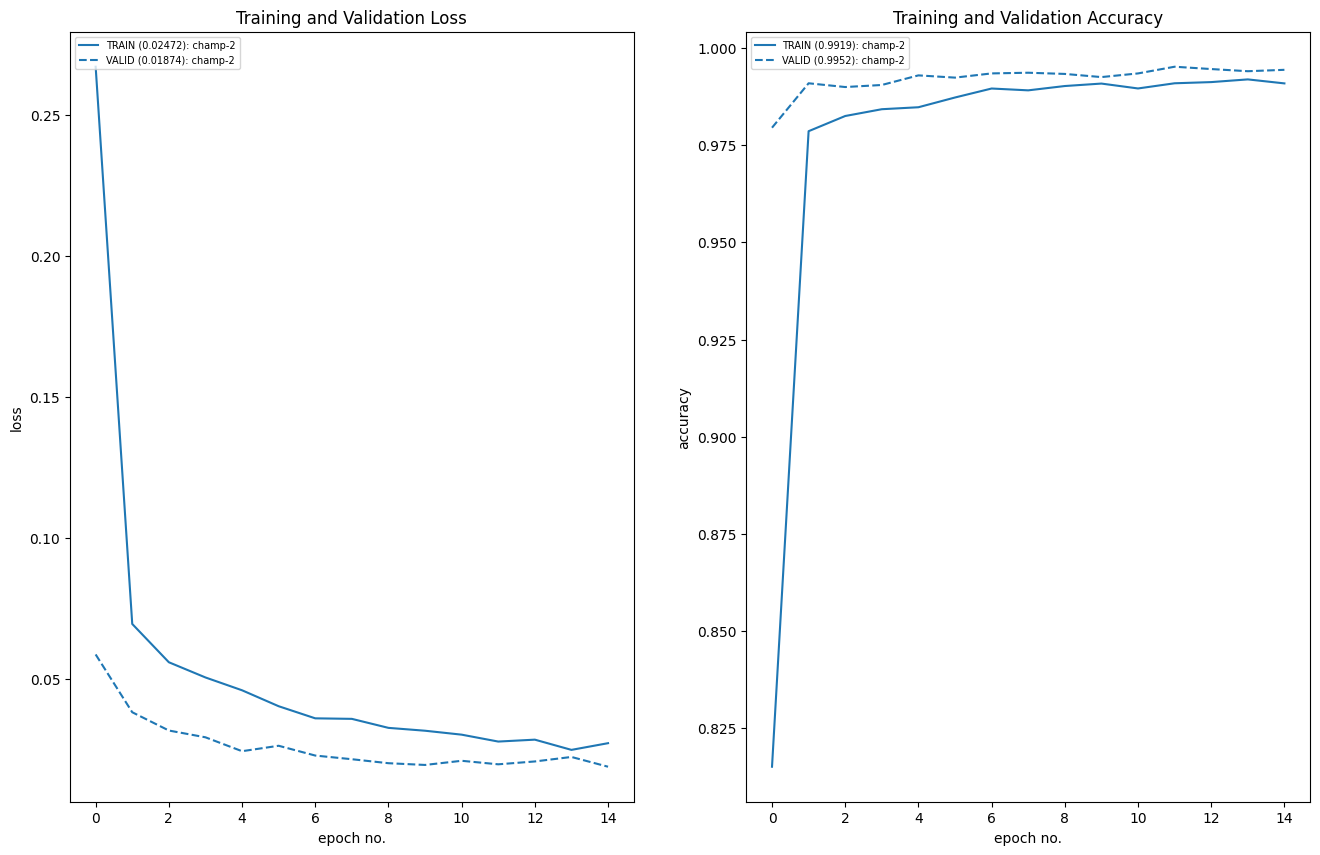

In [53]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champ-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:
1. Application of LR uisng ExponentialLR with GAP model
2. Increased validation Accuracy to great extent and far better than training accuracy

Results:\
Parameters: 7,114\
Best Training Accuracy: 99.19\
Best Test Accuracy: 99.52

Analysis:
1. Consistent improved performance on test data
2. Increased gap in performance on test data as compared to training data
3. Best Performing model so far